In [ ]:
# Raw Package
import numpy as np
import pandas as pd

# Visualization Package
import matplotlib.pyplot as plt

# import preprocessing functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# import keras library
from tensorflow import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, LSTM

#Data Source
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Interval required 5 minutes
data = yf.download(tickers='aapl', period='10y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Print data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-16,22.543215,22.741428,22.517857,22.726429,19.487864,254534000
2012-08-17,22.857143,23.149643,22.814644,23.146786,19.848320,442761200
2012-08-20,23.214643,23.755358,23.210714,23.755358,20.370165,613384800
2012-08-21,23.957857,24.102858,23.226070,23.430714,20.091784,812719600
2012-08-22,23.372143,23.892857,23.146786,23.888214,20.484089,565322800


In [ ]:
# check if there are missing values for each column
data.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

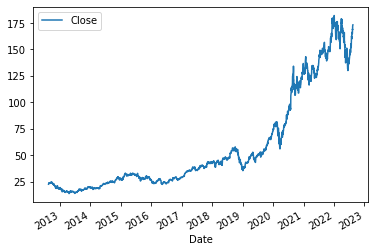

In [ ]:
data[['Close']].plot()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2012-08-16 to 2022-08-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2515 non-null   float64
 1   High       2515 non-null   float64
 2   Low        2515 non-null   float64
 3   Close      2515 non-null   float64
 4   Adj Close  2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


In [ ]:
# create a 7 and 80 moving average
data['7ma'] = data.rolling(7).mean()['Close']
data['60ma'] = data.rolling(60).mean()['Close']

# create a target column (1 if next close is higher than current close, else 0)
data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# drop open, high and low columns
data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)

data = data.dropna()

data.head()

,Close,Volume,7ma,60ma,target
Date,,,,,
2012-11-12,19.386786,515802000,20.050561,23.070649,1
2012-11-13,19.389286,532949200,19.877602,23.015030,0
2012-11-14,19.174286,477170400,19.634030,22.948821,0
2012-11-15,18.772142,789910800,19.342041,22.865768,1
2012-11-16,18.845715,1266893600,19.187347,22.789351,1


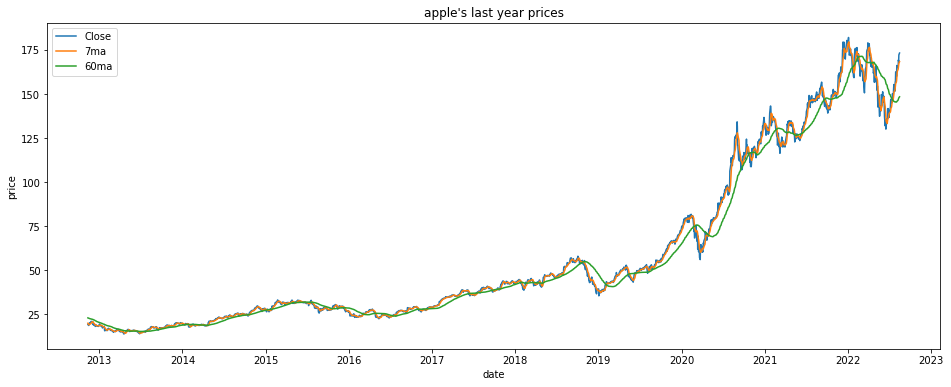

In [ ]:
# plot chart with the moving averages
plt.figure(figsize=[16,6])
plt.plot(data['Close'], label='Close')
plt.plot(data['7ma'], label='7ma')
plt.plot(data['60ma'], label='60ma')
plt.legend()
plt.title("apple's last year prices")
plt.xlabel('date')
plt.ylabel('price')
plt.show()

In [ ]:
# set features' range to [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

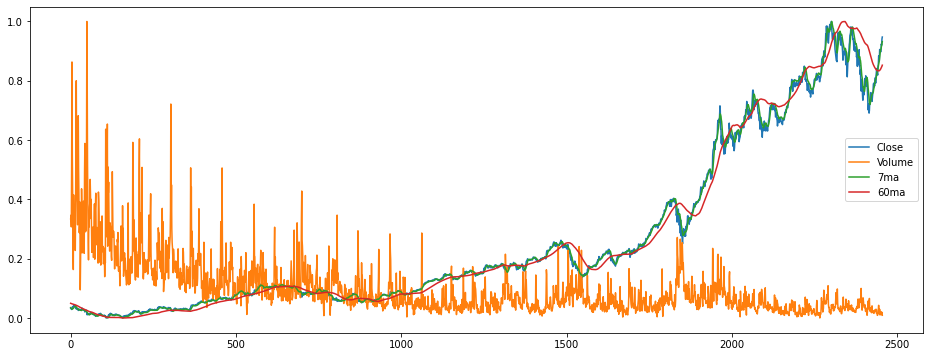

In [ ]:
pd.DataFrame(data_scaled[:,:-1], columns=data.columns.to_list()[:-1]).plot(figsize=[16,6])

In [ ]:
X, y = [], []

lookback = 60

for i in range(lookback, len(data_scaled)):
  X.append(data_scaled[i-lookback:i,:-1])
  y.append(data_scaled[i,-1])

X, y = np.array(X), np.array(y)

In [ ]:
# separete data in training data and test data
train_len = int(len(data)*0.8)

X_train, y_train = X[0:train_len], y[0:train_len]
X_test, y_test = X[train_len:], y[train_len:]

In [ ]:
X_test.shape, y_test.shape

((432, 60, 4), (432,))

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

#compile the RNN
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
X_train.shape, y_train.shape

((1964, 60, 4), (1964,))

In [ ]:
# fit the RNN to the training set
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
62/62 [==============================] - 22s 187ms/step - loss: 0.6939 - accuracy: 0.5097
Epoch 2/100
62/62 [==============================] - 11s 176ms/step - loss: 0.6916 - accuracy: 0.5285
Epoch 3/100
62/62 [==============================] - 6s 96ms/step - loss: 0.6925 - accuracy: 0.5285
Epoch 4/100
62/62 [==============================] - 6s 103ms/step - loss: 0.6925 - accuracy: 0.5295
Epoch 5/100
62/62 [==============================] - 6s 97ms/step - loss: 0.6921 - accuracy: 0.5280
Epoch 6/100
62/62 [==============================] - 7s 115ms/step - loss: 0.6919 - accuracy: 0.5285
Epoch 7/100
62/62 [==============================] - 11s 184ms/step - loss: 0.6919 - accuracy: 0.5285
Epoch 8/100
62/62 [==============================] - 12s 197ms/step - loss: 0.6923 - accuracy: 0.5285
Epoch 9/100
62/62 [==============================] - 6s 95ms/step - loss: 0.6918 - accuracy: 0.5285
Epoch 10/100
62/62 [==============================] - 6s 91ms/step - loss: 0.6918 - accura

In [ ]:
test_sample = X_train[:1]

def get_precision(model, X_test, y_test, threshold):
  '''
  Calculate precision: Number of true positives divided by all positive predicitions
  '''
  
  predictions = []

  for i in X_test:
    i = np.reshape(i, (1,i.shape[0], i.shape[1]))
    predicted = model.predict(i)
    predictions.append(int(predicted > threshold))
  results = pd.DataFrame({"predictions": predictions, "targets": y_test})
  results = results[results['predictions']==1]
  
  return len(results[results['predictions']==results['targets']])/len(results)


In [ ]:
precision = get_precision(model, X_test, y_test, 0.55)
print(precision)

0.5185185185185185
